 ## Cube-Based Random Sequential Adsorption

This algorithm is a bit easier to implement since cubes can be trivially drawn at any resolution. It follows a simple heuristic of the RSA system:
1. Fetch a uniform random sample over 3 independent numbers selected between 0 and 1, u1, u2, and u3.
   1. For the case of variable u1, rotate around the x-axis by (2 * pi) * u1 radians
   2. For the case of variable u2, rotate around the y-axis by arcsin(2 * u2 - 1) radians
   3. For the case of variable u3, rotate around the z-axis by (2 * pi) * u3 radians
2. After the rotation is done, move the cube to a random location via the mersienne twister algorithm (in cpp).
   1. We must provide indices which allow for a uniform distribution that does not violate the available index arrangement and dimensions of the RVE


In [142]:
import numpy as np
import itertools
import random

from typing import List, Tuple
from collections import namedtuple
import scipy.ndimage

Point3D = namedtuple('Point3D', ['x', 'y', 'z'])

class _Cube(object):
    def __init__(self, dim: int, starting_index: Tuple[int, int, int]):
        """_Cube is a 3D cube structure

        Args:
            dim (int): The dimension of the cube (dim x dim x dim)
            starting_index (Tuple[int, int, int]): The starting bottom_left base
            layer index of the cube
        """
        self.dim = dim
        self.indices = []

        _indices = []
        c_x, c_y, c_z = starting_index

        for z in range(self.dim):
            for y in range(self.dim):
                for x in range(self.dim):
                    _indices.append((c_x + x, c_y + y, c_z + z))

        self.indices = list(set(_indices))

    def __eq__(self, other: "_Cube") -> bool:
        """Checks equivalence by way of overlap in one of the 3 cases:
        1. Any vertex of self lies in other.
        2. Any vertex of other lies in self.
        3. Any edge of self crosses any face in self.

        Args:
            other (Cube): The cube to compare against.
        
        Returns:
            (bool): Whether or not the two overlap
        """
        for index in self.indices:
            if index in other.indices:
                return True

        return False

    def rotate(self, x_rot, y_rot, z_rot):
        _indices = np.array(self.indices)

        scipy.ndimage.rotate(_indices, x_rot)
        scipy.ndimage.rotate(_indices, y_rot)
        scipy.ndimage.rotate(_indices, z_rot)

        self.indices = _indices.tolist()


class RandomSequentialAdsorption(object):
    def __init__(self, n_cubes: int, cube_size: int, rve_size: int):
        self.n_cubes = n_cubes

        # Accounts for height, width, depth of cuboid inclusion
        self.cube_size = cube_size

        # Accounts for height, width, depth of resultant rve 
        self.rve_size = rve_size
        self.rve = np.ones((rve_size, rve_size, rve_size))

        self.cubes = []

    def generate_rve(
        self, 
        size_variability=1, 
        min_inclusion_separation=1, 
        max_iterations=1000
    ):
        base_min = 0

        # Ensures that the cutoff conditions are met
        base_max = self.rve_size - self.cube_size

        n_iterations = 0

        for i in range(self.n_cubes):
            u1 = random.uniform(0, 1)
            u2 = random.uniform(0, 1)
            u3 = random.uniform(0, 1)

            x_axis_rot = np.degrees(2 * np.pi * u1)
            y_axis_rot = np.degrees(np.arcsin(2 * u2 - 1))
            z_axis_rot = np.degrees(2 * np.pi * u3)

            rx = int(random.uniform(base_min, base_max))
            ry = int(random.uniform(base_min, base_max))
            rz = int(random.uniform(base_min, base_max))

            c = _Cube(self.cube_size, (rx, ry, rz))

            if len(self.cubes) > 0:
                for cube in self.cubes:
                    if cube == c:
                        while cube == c and n_iterations < max_iterations:
                            rx = int(random.uniform(base_min, base_max))
                            ry = int(random.uniform(base_min, base_max))
                            rz = int(random.uniform(base_min, base_max))

                            c = _Cube(self.cube_size, (rx, ry, rz))
                            n_iterations += 1
                        if n_iterations >= max_iterations:
                            raise RuntimeError('Iteration limit reached')
                        
            c.rotate(x_axis_rot, y_axis_rot, z_axis_rot)
            self.cubes.append(c)

        for cube in self.cubes:
            for index in cube.indices:
                layer, row, col = index
                self.rve[layer][row][col] = 0

        return self.rve



In [143]:
import matplotlib.pyplot as plt
import matplotlib

cmap = matplotlib.colors.ListedColormap(['r', 'k'])
norm = matplotlib.colors.BoundaryNorm([0., 0.5, 1.], cmap.N)

def imshow(data, cmap, norm):
    plt.imshow(data, cmap=cmap, norm=norm, interpolation='none')

rve = RandomSequentialAdsorption(n_cubes=10, cube_size=10, rve_size=50).generate_rve()

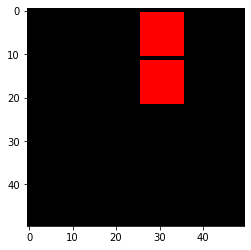

In [145]:
imshow(rve[28], cmap, norm)